In [1]:
# This file is associated with the book
# "Machine Learning Refined", Cambridge University Press, 2016.
# by Jeremy Watt, Reza Borhani, and Aggelos Katsaggelos.

import numpy as np
import numpy.matlib
import matplotlib.pyplot as plt
import csv
from __future__ import division

First - a simple data loading function.

In [2]:
# import training data 
def load_data(csvname):
    # load in data
    reader = csv.reader(open(csvname, "rb"), delimiter=",")
    d = list(reader)

    # import data and reshape appropriately
    data = np.array(d).astype("float")
    x = data[:,0:-1]
    y = data[:,-1]
    y.shape = (len(y),1)
    
    return x,y

A function to split our dataset into k folds.

In [3]:
# function for splitting dataset into k folds
def split_data(x,y,k):
    # split data into k equal (as possible) sized sets
    L = np.size(y)
    order = np.random.permutation(L)
    c = np.ones((L,1))
    L = np.round((1/k)*L)
    for s in np.arange(0,k-2):
        c[order[s*L:(s+1)*L]] = s + 2
    c[order[(k-1)*L:]] = k
    return c

A function to transform input into polynomial features. 

In [4]:
# takes poly features of the input 
def build_poly(data,D):
    F = []
    for n in range(D+1):
        for m in range(D+1):
            if n + m <= D:
                temp = (data[:,0]**n)*(data[:,1]**m)
                temp.shape = (len(temp),1)
                F.append(temp)
    F = np.asarray(F)
    F.shape = (np.shape(F)[0],np.shape(F)[1])
    return F

Up next - our cross-validation function where we perform k-fold cross-validation using our polynomial featurees.

In [5]:
# hold out cross-validating function
def cross_validate(X,y,c,max_deg,k):

    # solve for weights and collect test errors
    train_errors = []
    test_errors = []
    for i in range(1,max_deg):
        # generate features
        deg = i
        F = build_poly(X,deg)

        # compute testing errors
        train_resids = []
        test_resids = []
        for j in np.unique(c):
            F_1 = F[:,np.nonzero(c != j)[0]]
            y_1 = y[np.nonzero(c != j)[0]]
            F_2 = F[:,np.nonzero(c == j)[0]]
            y_2 = y[np.nonzero(c == j)[0]]

            # learn weights on training set
            w = squared_margin_newtons_method(F_1,y_1)

            # compute test error
            test_resid = count_misclasses(F_2,y_2,w)

            # compute training error
            train_resid = count_misclasses(F_1,y_1,w)

            # save this fold's results
            test_resids.append(test_resid)
            train_resids.append(train_resid)
            
        # save this degree's results
        test_errors.append(test_resids)
        train_errors.append(train_resids)
    
    # take average of test and train errors
    test_errors = np.asarray(test_errors)
    test_errors.shape = (np.shape(test_errors)[0],np.shape(test_errors)[1])
    test_errors = np.mean(test_errors,axis = 1)
    
    train_errors = np.asarray(train_errors)
    train_errors.shape = (np.shape(train_errors)[0],np.shape(train_errors)[1])
    train_errors = np.mean(train_errors,axis = 1)

    # find best degree
    best_deg = np.argmin(test_errors) + 1
    
    # plot training and testing errors
    plot_cv_scores(train_errors,test_errors,max_deg)
    return best_deg

All classification functionality - including calculation functions of the gradient and Hessian of the squared margin cost, a function to count misclassifications, and newton's method loop.

In [6]:
###### optimization functions #######
# function for computing gradient and Hessian for squared margin cost Newton's method
def squared_margin_grad_hess(X,y,w):
    hess = 0
    grad = 0
    for p in range(0,len(y)):
        # precompute        
        x_p = X[:,p]
        y_p = y[p]
        
        # update grad and hessian
        grad+= -2*max(0,1 - y_p*np.dot(x_p.T,w))*y_p*x_p
        
        if 1 - y_p*np.dot(x_p.T,w) > 0:
            hess+= 2*np.outer(x_p,x_p)
        
    grad.shape = (len(grad),1)
    return grad,hess

# run newton's method
def squared_margin_newtons_method(X,y):
    # begin newton's method loop    
    max_its = 15
    w = np.random.randn(np.shape(X)[0],1)
    for k in range(max_its):
        # compute gradient and Hessian
        grad,hess = squared_margin_grad_hess(X,y,w)

        # take Newton step
        hess = hess + 10**-6*np.diag(np.ones((np.shape(X)[0])))
        temp = np.dot(hess,w) - grad        
        w = np.dot(np.linalg.pinv(hess),temp)
    return w

# function for counting the number of misclassifications
def count_misclasses(X,y,w):
    y_pred = np.sign(np.dot(X.T,w))
    num_misclassed = len(y) - len([i for i, j in zip(y, y_pred) if i == j])
    return num_misclassed

Now we need plotting functions - to plot both the average training / testing scores, our dataset, and the best nonlinear separation of the data.

In [7]:
# plot training and testing errors
def plot_cv_scores(train_errors,test_errors,max_deg):
    # plot training and testing errors
    fig = plt.figure(figsize = (5,5))
    plt.plot(np.arange(1,max_deg),train_errors,marker = 'o',color = [0,0.7,1])
    plt.plot(np.arange(1,max_deg),test_errors,marker = 'o',color = [1,0.8,0.5])

    # clean up plot
    plt.xlim([0.7, max_deg + 0.3])
    plt.ylim([min(min(train_errors),min(test_errors)) - 0.05,max(max(train_errors),max(test_errors)) + 0.05]);
    plt.xlabel('parameter values')
    plt.ylabel('error')
    plt.xticks(np.arange(1,max_deg));
    plt.title('ave cross validation errors',fontsize = 14)
    plt.legend(['ave training error','ave testing error'],loc='center left', bbox_to_anchor=(1, 0.5))

# plotting function
def plot_model(X,y,best_deg):
    fig = plt.figure(figsize = (5,5))

    # calculate weights
    F = build_poly(X,best_deg)
    w = squared_margin_newtons_method(F,y)
    
    # plot points
    ind0 = np.argwhere(y == -1)
    ind0 = [v[0] for v in ind0]
    ind1 = np.argwhere(y == 1)
    ind1 = [v[0] for v in ind1]
    plt.scatter(X[ind0,0],X[ind0,1],c = 'r')
    plt.scatter(X[ind1,0],X[ind1,1],c = 'b')

    # create proper contour
    r = np.linspace(0,1,100)
    s,t = np.meshgrid(r,r)
    s = np.reshape(s,(np.size(s),1))
    t = np.reshape(t,(np.size(t),1))
    h = np.concatenate((s,t),axis = 1)
    F_h = build_poly(h,best_deg)
    z = np.dot(F_h.T,w)
    
    # plot contour
    s.shape = (len(r),len(r))
    t.shape = (len(r),len(r))
    z.shape = (len(r),len(r))

    plt.contour(s,t,z,colors='k', linewidths=3.5,levels = [0],zorder = 2)

Now that everything is defined, run all.

/Users/Nurgetson/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:9: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/Nurgetson/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:10: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


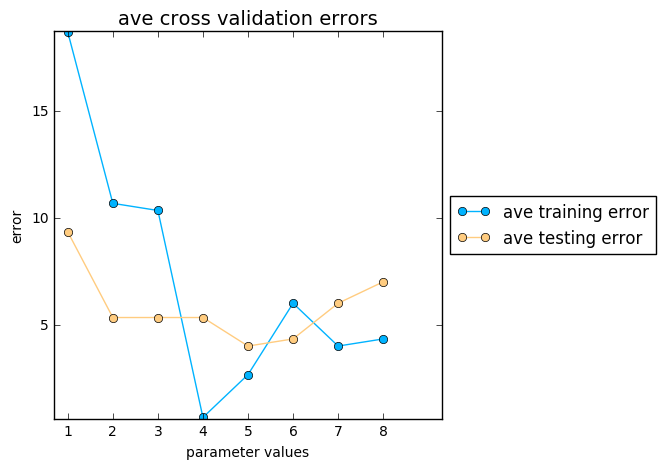

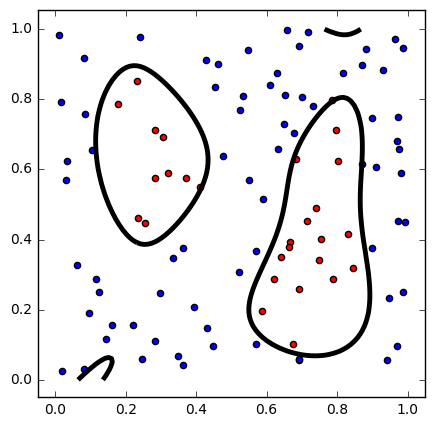

In [9]:
# run all
X,y = load_data('2eggs_data.csv')

# make folds
k = 3
c = split_data(X,y,k)

# cross validate
max_deg = 8
best_deg = cross_validate(X,y,c,max_deg+1,k)

# plot model
plot_model(X,y,best_deg)
plt.show()